In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib
from matplotlib import pyplot as plt
from sklearn import linear_model as lm
from matplotlib import cm
import scipy.stats as st
%matplotlib notebook

In [2]:
conn = sqlite3.connect('douban_us_movie.sqlite')
crsr = conn.cursor()

# Load data from SQL

In [3]:
# Load data from Movie Table
crsr.execute('SELECT DBrating, IMDBratingUS, IMDBrating, DBreview_count, IMDBreview_count, IMDBgenre, TitleEN, DirectorsEN, CastsEN, BO_domestic, Budget, BO_CHN, BO_FOREIGN, USrelease \
            FROM Movie WHERE DBreview_count is not NULL and BO_domestic is not NULL and Budget is not NULL')
data = crsr.fetchall()
df = pd.DataFrame(data, columns=['DBrating', 'IMDBratingUS', 'IMDBrating', 'DBreview_count', 'IMDBreview_count',
                                 'Genre', 'Title', 'Directors', 'Casts', 'Box office domestic', 'budget', 'Box office CN', 'Box office foreign', 'USrelease'])
print(df.shape)
df.head()

(4136, 14)


,DBrating,IMDBratingUS,IMDBrating,DBreview_count,IMDBreview_count,Genre,Title,Directors,Casts,Box office domestic,budget,Box office CN,Box office foreign,USrelease
0,8.2,8.1,8.0,246840,"147,449",Action/Adventure/Thriller/,Mission: Impossible - Fallout,Christopher McQuarrie,Tom Cruise/Henry Cavill/Ving Rhames/Simon Pegg/,"$220,159,104",$178 million,"$181,184,137","$570,956,000",27 July 2018 (USA)
1,7.4,7.4,7.2,187869,"141,007",Action/Adventure/Comedy/Sci-Fi/,Ant-Man and the Wasp,Peyton Reed,Paul Rudd/Evangeline Lilly/Michael Peña/Walton...,"$216,648,740","$162,000,000","$121,203,074","$406,025,399",6 July 2018 (USA)
2,6.3,6.2,6.1,22171,"24,070",Action/Adventure/Comedy/,The Spy Who Dumped Me,Susanna Fogel,Justin Theroux/Blanka Györfi-Tóth/Vilma Szécsi...,"$33,562,069",$40 million,"$8,895,647","$41,756,475",3 August 2018 (USA)
3,9.4,8.7,8.8,933844,"1,532,393",Drama/Romance/,Forrest Gump,Robert Zemeckis,Tom Hanks/Robin Wright/Gary Sinise/Sally Field/,"$329,694,499",$55 million,"$2,350,120","$347,693,217",6 July 1994 (USA)
4,9.3,8.7,8.8,953369,"1,760,580",Action/Adventure/Sci-Fi/Thriller/,Inception,Christopher Nolan,Leonardo DiCaprio/Joseph Gordon-Levitt/Ellen P...,"$292,576,195",$160 million,"$68,445,823","$535,745,837",16 July 2010 (USA)


In [4]:
# Load data from Directors
crsr.execute('SELECT EN_name, DB_Follower FROM Directors')
director_data = crsr.fetchall()
df_directors = pd.DataFrame(director_data, columns=['Directors', 'DB Followers'])
df_directors = df_directors.set_index('Directors')

# Function that calculates director popularity
def dr_db_followers(x):
    if x in df_directors.index:
        return df_directors.loc[x, 'DB Followers']
    elif '/' in x:
        x_split = x.split('/')
        x_split.pop()
        sum=0
        i=0
        for x_i in x_split:
            if x_i in df_directors.index:
                sum+=df_directors.loc[x_i, 'DB Followers']
                i+=1
            else:
                continue
        return sum/(i+1)
    elif x is None:
        return 0
df['DR_DB_Followers'] = df['Directors'].apply(dr_db_followers)

In [5]:
# Load data from Casts
crsr.execute('SELECT EN_name, DB_Follower FROM Casts')
cast_data = crsr.fetchall()
df_casts = pd.DataFrame(cast_data, columns=['Casts', 'DB Followers'])
df_casts = df_casts.set_index('Casts')

# Function that calculates cast popularity
def cast_db_followers(x):
    if x in df_casts.index:
        return df_casts.loc[x, 'DB Followers']
    elif '/' in x:
        x_split = x.split('/')
        if x_split[0] in df_casts.index:
            return df_casts.loc[x_split[0], 'DB Followers']
    else:
        return 0
df['CAST_DB_Followers'] = df['Casts'].apply(cast_db_followers)

# Data cleaning and processing

In [6]:
## convert budget to in million to numerical value
def budget_converter(x):
    if 'million' in x:
        x = x.replace('$', '').replace('million', '').replace(',', '')
        x = float(x)
        x = x*10**6
        x = str(x)
    elif x!='N/A':
        x = x.replace('$', '').replace(',', '')
#     elif x='0'
    return x

df['budget'] = df['budget'].apply(budget_converter)
df['budget'] = pd.to_numeric(df['budget'],errors='coerce')

In [10]:
sum(df['Box office foreign'] == 'N/A')

558

In [11]:
## Delete rows where DBrating is blank or 0
df = df[(df['DBrating']!='') & (df['DBrating']!='0')]

## remove comma from count
df['IMDBreview_count'] = df['IMDBreview_count'].str.replace(',', '')
## remove comma and $ sign from box office
df['Box office domestic'] = df['Box office domestic'].str.replace(',', '').str.replace('$', '')
df['Box office CN'] = df['Box office CN'].str.replace(',', '').str.replace('$', '')
df['Box office foreign'] = df['Box office foreign'].str.replace(',', '').str.replace('$', '')
df['Box office foreign'] = df['Box office foreign'].str.replace('FOREIGN TOTAL', 'N/A')

## specify data type
df['DBrating'] = df['DBrating'].astype(float)
df['IMDBrating'] = df['IMDBrating'].astype(float)
df['DBreview_count']=df['DBreview_count'].astype(int)
df['IMDBreview_count'] = df['IMDBreview_count'].astype(int)
df['Box office domestic'] = pd.to_numeric(df['Box office domestic'], errors='coerce')
df['Box office CN'] = pd.to_numeric(df['Box office CN'], errors='coerce')
df['Box office foreign'] = pd.to_numeric(df['Box office foreign'], errors='coerce')

## create dummy variables for genre
df_genre = df['Genre'].str.replace('D/r/a/m/a/', 'Drama').str.replace('/', ' ').str.split()
genre = []
for i, j in df_genre.iteritems():
    if j is None:
        continue
    else: genre = genre + j

uniq_genre = list(set(genre))
for i in uniq_genre:
    df[i] = df_genre.apply(lambda x: i in x if x is not None else False)
    
df['All Genre'] = True
df.head()

,DBrating,IMDBratingUS,IMDBrating,DBreview_count,IMDBreview_count,Genre,Title,Directors,Casts,Box office domestic,...,Western,News,War,Comedy,Sport,Sci-Fi,Biography,Crime,Drama,All Genre
0,8.2,8.1,8.0,246840,147449,Action/Adventure/Thriller/,Mission: Impossible - Fallout,Christopher McQuarrie,Tom Cruise/Henry Cavill/Ving Rhames/Simon Pegg/,220159104.0,...,False,False,False,False,False,False,False,False,False,True
1,7.4,7.4,7.2,187869,141007,Action/Adventure/Comedy/Sci-Fi/,Ant-Man and the Wasp,Peyton Reed,Paul Rudd/Evangeline Lilly/Michael Peña/Walton...,216648740.0,...,False,False,False,True,False,True,False,False,False,True
2,6.3,6.2,6.1,22171,24070,Action/Adventure/Comedy/,The Spy Who Dumped Me,Susanna Fogel,Justin Theroux/Blanka Györfi-Tóth/Vilma Szécsi...,33562069.0,...,False,False,False,True,False,False,False,False,False,True
3,9.4,8.7,8.8,933844,1532393,Drama/Romance/,Forrest Gump,Robert Zemeckis,Tom Hanks/Robin Wright/Gary Sinise/Sally Field/,329694499.0,...,False,False,False,False,False,False,False,False,True,True
4,9.3,8.7,8.8,953369,1760580,Action/Adventure/Sci-Fi/Thriller/,Inception,Christopher Nolan,Leonardo DiCaprio/Joseph Gordon-Levitt/Ellen P...,292576195.0,...,False,False,False,False,False,True,False,False,False,True


In [12]:
df.to_csv('Cleaned_data_new.csv', index=False)

In [149]:
df2['IMDBreview_count'].astype(int)

0        147449
1        141007
2         24070
3       1532393
4       1760580
5        212388
6       2011889
7          2784
8        236657
9        804024
10      1223512
11       869355
12      1007305
13       515095
14       392464
15         7055
16       339549
17       515849
18       916632
19          738
20       122389
21       808852
23       358933
24      1130952
25       408423
26       230744
27       114575
28       456795
29        81973
30        72619
         ...   
7552      17742
7553       4410
7554     107845
7555      15240
7556      27956
7557      11805
7558      15907
7559        215
7562         94
7564        820
7565       3194
7566      21679
7568      14848
7569       1265
7570      50346
7571        629
7572        400
7573      13025
7577       6165
7578      38676
7579       7750
7580      38501
7581        940
7582       8192
7583       1572
7587        865
7588      66136
7590      27382
7591      32960
7592      21847
Name: IMDBreview_count, 

In [38]:
for name in list(df['Directors'].values):
    if name is None:
        continue
    if '/' in name:
        name_split = name.split('/')
        name_split.pop()
        director_list += name_split
    else: director_list.append(name)

In [41]:
len(set(director_list))

3370

In [14]:
df.describe()

,DBrating,IMDBratingUS,IMDBrating,DBreview_count,IMDBreview_count,Genre,Title,Directors,Casts,Box office domestic,budget
count,6998,6998,6998,6998,6998,6991,6996,6245,6935,4134,4134
unique,71,80,78,5645,6339,1215,6805,3074,6385,3518,224
top,7.6,7.5,7.1,207,124,Comedy,The Victoria's Secret Fashion Show,Woody Allen,Dan Castellaneta/Julie Kavner/Nancy Cartwright...,"$605,764",N/A
freq,260,255,265,6,7,284,5,44,24,8,2072


In [10]:
df = df[(df['DBrating']!='') & (df['DBrating']!='0')]

In [11]:
df['DBrating'] = df['DBrating'].astype(float)
df['IMDBrating'] = df['IMDBrating'].astype(float)

In [12]:
df['Diff_rating'] = df['DBrating'] - df['IMDBrating']
df['IMDBreview_count'] = df['IMDBreview_count'].str.replace(',', '')

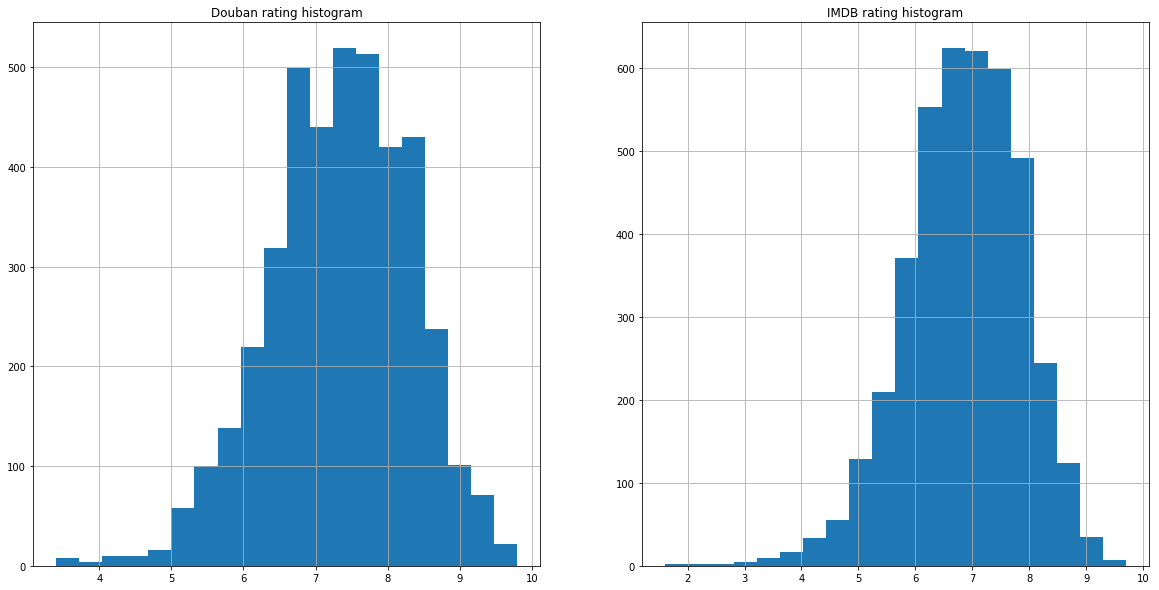

In [16]:
plt.figure(figsize = (20,10))
plt.subplot(1, 2, 1)
plt.title('Douban rating histogram')
df['DBrating'].hist(bins=20)

plt.subplot(1, 2, 2)
plt.title('IMDB rating histogram')
df['IMDBrating'].hist(bins=20)

In [14]:
df['DBreview_count']=df['DBreview_count'].astype(int)
df['IMDBreview_count'] = df['IMDBreview_count'].astype(int)

In [8]:
df_genre = df['Genre'].str.replace('D/r/a/m/a/', 'Drama').str.replace('/', ' ').str.split()

In [16]:
df_genre.loc[3614]

In [11]:
uniq_genre

['Musical',
 'Reality-TV',
 'Biography',
 'Film-Noir',
 'Family',
 'Horror',
 'Action',
 'Romance',
 'Western',
 'Game-Show',
 'Talk-Show',
 'War',
 'History',
 'Adventure',
 'Fantasy',
 'Documentary',
 'Comedy',
 'News',
 'Drama',
 'Thriller',
 'Adult',
 'Short',
 'Crime',
 'Sport',
 'Sci-Fi',
 'Animation',
 'Mystery',
 'Music']

In [19]:
for i in uniq_genre:
    df[i] = df_genre.apply(lambda x: i in x if x is not None else None)

In [20]:
df.sort_values('DBreview_count', ascending=False)

,DBrating,IMDBratingUS,IMDBrating,DBreview_count,IMDBreview_count,Genre,Title,Diff_rating,Film-Noir,Western,...,Comedy,News,History,Sci-Fi,War,Fantasy,Animation,Action,Crime,Adult
6,9.6,9.3,9.3,1184569,2011889,Drama,The Shawshank Redemption,0.3,False,False,...,False,False,False,False,False,False,False,False,False,False
4,9.3,8.7,8.8,953369,1760580,Action/Adventure/Sci-Fi/Thriller/,Inception,0.5,False,False,...,False,False,False,True,False,False,False,True,False,False
3,9.4,8.7,8.8,933844,1532393,Drama/Romance/,Forrest Gump,0.6,False,False,...,False,False,False,False,False,False,False,False,False,False
18,9.3,7.7,7.8,870100,916632,Drama/Romance/,Titanic,1.5,False,False,...,False,False,False,False,False,False,False,False,False,False
30,9.0,7.5,7.7,739149,72619,Comedy/Drama/Romance/,Flipped,1.3,False,False,...,True,False,False,False,False,False,False,False,False,False
13,9.0,7.9,7.9,709191,515095,Adventure/Drama/Fantasy/,Life of Pi,1.1,False,False,...,False,False,False,False,False,True,False,False,False,False
23,9.1,8.0,8.0,698660,358933,Animation/Adventure/Comedy/Crime/Family/Mystery/,Zootopia,1.1,False,False,...,True,False,False,False,False,False,True,False,True,False
14,9.0,7.7,8.0,688144,392464,Biography/Drama/,The Pursuit of Happyness,1.0,False,False,...,False,False,False,False,False,False,False,False,False,False
10,9.2,8.4,8.6,641721,1223512,Adventure/Drama/Sci-Fi/,Interstellar,0.6,False,False,...,False,False,False,True,False,False,False,False,False,False
11,9.3,8.4,8.4,631602,869355,Animation/Adventure/Family/Sci-Fi/,WALL·E,0.9,False,False,...,False,False,False,True,False,False,True,False,False,False


In [21]:
list = []
for i in uniq_genre:
    IMDB_genre_avg_count = df[df[i]==True]['IMDBreview_count'].astype(int).mean()
    DB_genre_avg_count = df[df[i]==True]['DBreview_count'].astype(int).mean()
    genre_Diff_rating = df[df[i]==True]['Diff_rating'].mean()
    list.append((i, IMDB_genre_avg_count, DB_genre_avg_count, genre_Diff_rating))

In [22]:
Genre_data = pd.DataFrame(list, columns=['Genre', 'IMDB Avg Rev Count', 'DB Avg Rev Count', 'Mean Rating Diff'])

In [27]:
Genre_data.sort_values('DB Avg Rev Count', ascending=False).iloc[0:10]

,Genre,IMDB Avg Rev Count,DB Avg Rev Count,Mean Rating Diff
8,Adventure,147641.852761,55088.595968,0.531814
21,Sci-Fi,126428.698429,44597.305759,0.401990
23,Fantasy,110372.408516,43277.483314,0.481818
25,Action,130371.081159,42245.270290,0.352319
22,War,107656.047170,39533.452830,0.413679
3,Family,73932.014946,38124.717391,0.980571
10,Romance,69450.863002,33691.924528,0.560952
5,Musical,75983.161491,33310.521739,0.816770
20,History,87533.038136,31822.491525,0.436017
13,Thriller,101993.655987,30931.283305,0.306352


In [26]:
Genre_data.sort_values('IMDB Avg Rev Count', ascending=False).iloc[0:10]

,Genre,IMDB Avg Rev Count,DB Avg Rev Count,Mean Rating Diff
8,Adventure,147641.852761,55088.595968,0.531814
25,Action,130371.081159,42245.270290,0.352319
21,Sci-Fi,126428.698429,44597.305759,0.401990
23,Fantasy,110372.408516,43277.483314,0.481818
22,War,107656.047170,39533.452830,0.413679
1,Western,105335.329114,24084.759494,0.416456
13,Thriller,101993.655987,30931.283305,0.306352
26,Crime,99867.120036,26026.572202,0.351354
20,History,87533.038136,31822.491525,0.436017
15,Biography,86773.221607,30166.000000,0.499446


In [44]:
Genre_data.sort_values('Mean Rating Diff', ascending=False).iloc[0:10]

,Genre,IMDB Avg Rev Count,DB Avg Rev Count,Mean Rating Diff
9,Game-Show,2174.578947,2278.473684,1.073684
12,Talk-Show,2260.333333,354.333333,1.000000
3,Family,73932.014946,38124.717391,0.980571
24,Animation,51223.643662,27336.939437,0.924648
17,Reality-TV,2303.281250,2826.343750,0.881250
14,Documentary,9151.109890,5169.190476,0.860073
11,Music,49811.597938,21566.932990,0.829381
5,Musical,75983.161491,33310.521739,0.816770
4,Short,4102.613636,8030.859091,0.783182
19,News,13165.166667,4269.833333,0.750000


In [37]:
top10_DB = Genre_data.sort_values('DB Avg Rev Count', ascending=False).iloc[0:10]

In [38]:
top10_genre_DB = top10_DB['Genre'].tolist()

In [39]:
top10_genre_DB

['Adventure',
 'Sci-Fi',
 'Fantasy',
 'Action',
 'War',
 'Family',
 'Romance',
 'Musical',
 'History',
 'Thriller']

In [40]:
means_DBgenre = []
sd_DBgenre = []
for i in top10_genre_DB:
    means_DBgenre.append(df[df[i]==True]['DBrating'].mean())
    sd_DBgenre.append(df[df[i]==True]['DBrating'].std())

<IPython.core.display.Javascript object>


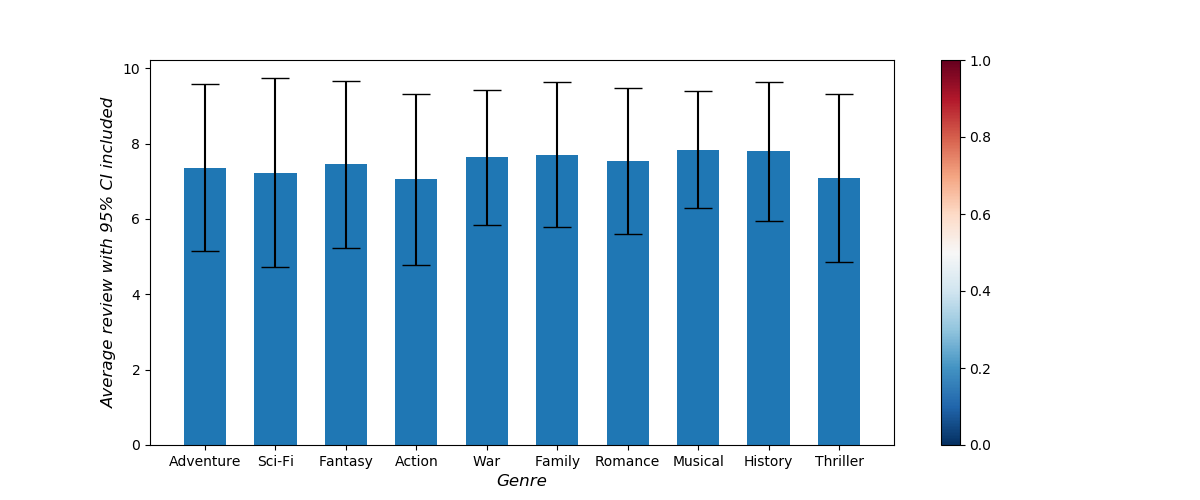

In [43]:
plt.figure(figsize=(12,5))

xvals = top10_genre_DB

# 95% CI
means_DBgenre=np.array(means_DBgenre)
sd_DBgenre=np.array(sd_DBgenre)
yerrbar = sd_DBgenre*1.96 

barplot=plt.bar(xvals, means_DBgenre, width = 0.6,yerr=yerrbar,capsize=10)
plt.xticks(xvals)
plt.ylabel('Average review with 95% CI included',fontsize='large',fontstyle='italic')
plt.xlabel('Genre',fontsize='large',fontstyle='italic')

# setup the colorbar
scalarmappaple = cm.ScalarMappable(cmap=cm.RdBu_r)
scalarmappaple.set_array(np.arange(0,1.1,0.1))
plt.colorbar(scalarmappaple)

def onclick(event):
    
    plt.cla()
    
    # add color for bars
    y=event.ydata
    
    # determine color shade based on the cdf under normal distribution
    prob=st.norm.cdf((y - means_genre)/sd_genre)
    color=cm.RdBu(prob)
    
    barplot=plt.bar(xvals, means_genre, width = 0.6,yerr=yerrbar,capsize=10,color=color)
    plt.xticks(xvals)
    plt.ylabel('Average review with 95% CI included',fontsize='large',fontstyle='italic')
    plt.xlabel('Genre',fontsize='large',fontstyle='italic')

    # add horizontal line
    plt.axhline(y)
    plt.gca().set_title('Colorbars corresponding to review score= {0:.2f}'.format(event.ydata))

#plt.gcf().canvas.mpl_connect('button_press_event', onclick)

In [46]:
top10_IMDB = Genre_data.sort_values('IMDB Avg Rev Count', ascending=False).iloc[0:10]
top10_genre_IMDB = top10_IMDB['Genre'].tolist()

In [50]:
means_IMDBgenre = []
sd_IMDBgenre = []
for i in top10_genre_IMDB:
    means_IMDBgenre.append(df[df[i]==True]['IMDBrating'].mean())
    sd_IMDBgenre.append(df[df[i]==True]['IMDBrating'].std())

<IPython.core.display.Javascript object>


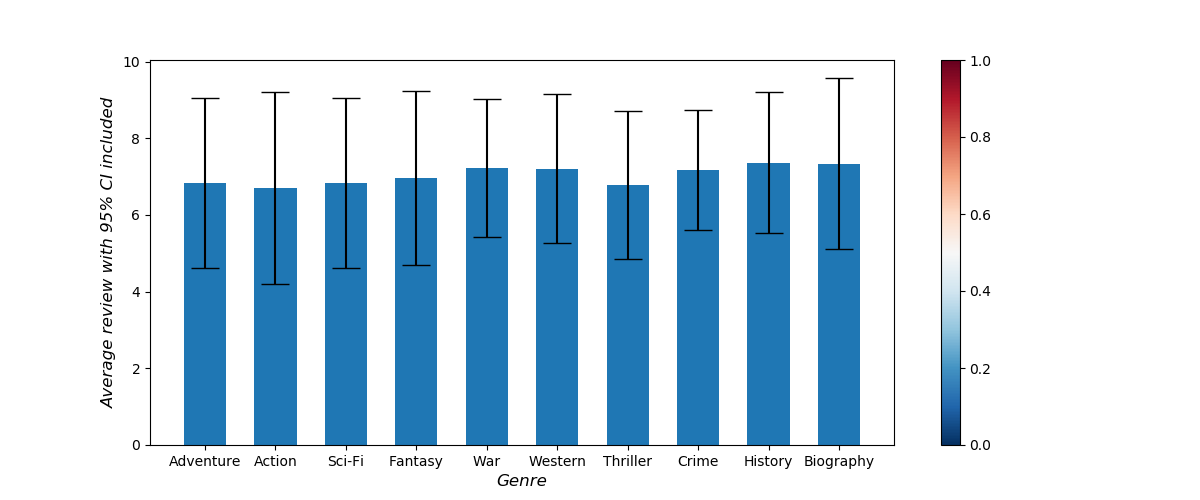

In [51]:
plt.figure(figsize=(12,5))

xvals = top10_genre_IMDB

# 95% CI
means_IMDBgenre=np.array(means_IMDBgenre)
sd_IMDBgenre=np.array(sd_IMDBgenre)
yerrbar = sd_DBgenre*1.96 

barplot=plt.bar(xvals, means_IMDBgenre, width = 0.6,yerr=yerrbar,capsize=10)
plt.xticks(xvals)
plt.ylabel('Average review with 95% CI included',fontsize='large',fontstyle='italic')
plt.xlabel('Genre',fontsize='large',fontstyle='italic')

# setup the colorbar
scalarmappaple = cm.ScalarMappable(cmap=cm.RdBu_r)
scalarmappaple.set_array(np.arange(0,1.1,0.1))
plt.colorbar(scalarmappaple)

def onclick(event):
    
    plt.cla()
    
    # add color for bars
    y=event.ydata
    
    # determine color shade based on the cdf under normal distribution
    prob=st.norm.cdf((y - means_genre)/sd_genre)
    color=cm.RdBu(prob)
    
    barplot=plt.bar(xvals, means_genre, width = 0.6,yerr=yerrbar,capsize=10,color=color)
    plt.xticks(xvals)
    plt.ylabel('Average review with 95% CI included',fontsize='large',fontstyle='italic')
    plt.xlabel('Genre',fontsize='large',fontstyle='italic')

    # add horizontal line
    plt.axhline(y)
    plt.gca().set_title('Colorbars corresponding to review score= {0:.2f}'.format(event.ydata))

#plt.gcf().canvas.mpl_connect('button_press_event', onclick)

In [30]:
ch_rating = df['DBrating']
us_rating = df['IMDBrating']
#clist = ch_rating.tolist()+us_rating.tolist()
#max_review=max(clist)+0.5
#min_review=min(clist)-0.5

In [31]:
ch_rating.describe()

count    4431.000000
mean        7.564094
std         1.094041
min         2.900000
25%         6.800000
50%         7.600000
75%         8.300000
max         9.800000
Name: DBrating, dtype: float64

In [32]:
ch_rating = ch_rating.astype(float)

In [33]:
us_rating = us_rating.astype(float)

In [34]:
clist = ch_rating.tolist()+us_rating.tolist()
max_review=max(clist)+0.5
min_review=min(clist)-0.5

In [35]:
regr = lm.LinearRegression()
regr.fit(us_rating.as_matrix().reshape((-1,1)), ch_rating.as_matrix().reshape((-1,1)))

c:\users\lorryon\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [36]:
slp=regr.coef_[0,0]
intp=regr.intercept_[0]

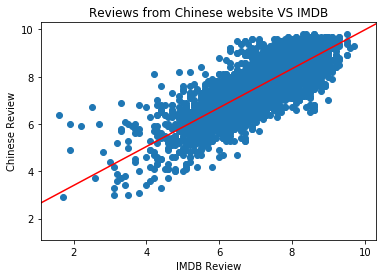

In [37]:
plt.figure()
plt.scatter(us_rating,ch_rating)
plt.xlim(min_review,max_review)
plt.ylim(min_review,max_review)
plt.ylabel("Chinese Review")
plt.xlabel("IMDB Review")
plt.title("Reviews from Chinese website VS IMDB")

# add linear regression line
x_val=np.array([min_review,max_review])
y_val=slp*x_val+intp
plt.plot(x_val, y_val, color='red')